In [2]:
import pandas as pd

In [3]:
# path to fasta file with restriction enzyme recognition sequence:
fasta_file_re = "lab_enzymes.fa"
# path to genome file
genome = "../genome.fa"

!seqkit locate --bed -f $fasta_file_re $genome -j 34 -F > lab_enzymes.bed
!awk -F "\t" '{print $1 "\t" $2 "\t" $4}' lab_enzymes.bed > lab_enzymes_3c.bed

In [4]:
enzyme_list = pd.read_csv("lab_enzymes_3c.bed", sep="\t", names=['Chr', 'cutsite', 'name'])
enzyme_list

,Chr,cutsite,name
0,I,14991,SapI
1,I,33761,SapI
2,I,59214,SapI
3,I,69236,SapI
4,I,82027,SapI
...,...,...,...
2624180,MtDNA,811,MboI
2624181,MtDNA,7907,EcoRV-HF
2624182,MtDNA,4810,EcoRV-HF
2624183,MtDNA,3347,EcoRV-HF


In [5]:
chromosomes = enzyme_list['Chr'].unique()
print(chromosomes)
enzymes = enzyme_list['name'].unique()
print(enzymes)

Chrom_sizes = {
    'I' : 15072434,
    'II' : 15279421,
    'III' : 13783801,
    'IV' : 17493829,
    'V' : 20924180,
    'X' : 17718942,
    'MtDNA' : 13794
}
print(Chrom_sizes)

['I' 'II' 'III' 'IV' 'V' 'X' 'MtDNA']
['SapI' 'ApaI' 'XhoI' 'BamHI-HF' 'NaeI' 'NcoI' 'SacI-HF' 'NdeI' 'SalI-HF'
 'PstI-HF' 'BsmAI' 'XbaI' 'BglII' 'AflII' 'ApaLI' 'EagI-HF' 'EcoRI-HF'
 'PvuII' 'EcoRV-HF' 'PmlI' 'NheI' 'SacII' 'KpnI-HF' 'HindIII-HF' 'HpaII'
 'DpnI' 'DraI' 'MboI']
{'I': 15072434, 'II': 15279421, 'III': 13783801, 'IV': 17493829, 'V': 20924180, 'X': 17718942, 'MtDNA': 13794}


In [6]:
enzyme_list.query('Chr == "I"')

,Chr,cutsite,name
0,I,14991,SapI
1,I,33761,SapI
2,I,59214,SapI
3,I,69236,SapI
4,I,82027,SapI
...,...,...,...
414036,I,3974,MboI
414037,I,3749,MboI
414038,I,3680,MboI
414039,I,2674,MboI


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

print(enzymes)
def digest(zyme1, zyme2):
    all_chr_fragment_lengths = []
    for chr in chromosomes:
        enzyme_1_df = enzyme_list.query('Chr == @chr & name == @zyme1')
        enzyme_2_df = enzyme_list.query('Chr == @chr & name == @zyme2')
        # Querying the chromosomes and enzymes provided and return a new dataframe
        list_of_enzyme_1_cutsites = enzyme_1_df['cutsite'].to_list()
        list_of_enzyme_2_cutsites = enzyme_2_df['cutsite'].to_list()
        # Making lists for the two enzyme cutting sites
        all_cutsites_list = list_of_enzyme_1_cutsites + list_of_enzyme_2_cutsites
        all_cutsites_list.append(1)
        all_cutsites_list.append(Chrom_sizes[chr])
        # Merging the two lists into one and add "1" and "chromosome length" to the list
        set_of_all_cutsites = set(all_cutsites_list)
        all_cutsites_list = list(set_of_all_cutsites)
        # Render the cut sites unique before sorting
        all_cutsites_list.sort()

        fragment_length = []
        last_position = 0
        for i in all_cutsites_list:
            if(last_position == 0):
                last_position = i
            else:
                fragment_length.append(i - last_position)
                last_position = i
        for item in fragment_length:
            all_chr_fragment_lengths.append(item)
        # Making the difference between the adjacent two items in the list 
    target_fragment_basepair = 0
    for i in all_chr_fragment_lengths:
        if (i > 1500) and (i < 3000):
            target_fragment_basepair += i
    ratio = round(500000000/target_fragment_basepair)
    
    #plt.figure(figsize=(10, 6))
    plt.hist(all_chr_fragment_lengths, bins=100,  label=str(zyme1 + ' & ' + zyme2 ))
    plt.title(str(zyme1 + ' & ' + zyme2 ))
    plt.yscale('log')
    q95 = np.quantile(all_chr_fragment_lengths, q=0.95)
    plt.text(0, 600, "95 quantile: " + str(round(q95)))
    plt.text(0, 300, "array proportion in 1.5 - 3 kb band = " + str(ratio) + " %")
    #plt.xlim(0,df['length'].max())
    plt.savefig(zyme1 + " & " + zyme2)
    plt.show()

['SapI' 'ApaI' 'XhoI' 'BamHI-HF' 'NaeI' 'NcoI' 'SacI-HF' 'NdeI' 'SalI-HF'
 'PstI-HF' 'BsmAI' 'XbaI' 'BglII' 'AflII' 'ApaLI' 'EagI-HF' 'EcoRI-HF'
 'PvuII' 'EcoRV-HF' 'PmlI' 'NheI' 'SacII' 'KpnI-HF' 'HindIII-HF' 'HpaII'
 'DpnI' 'DraI' 'MboI']


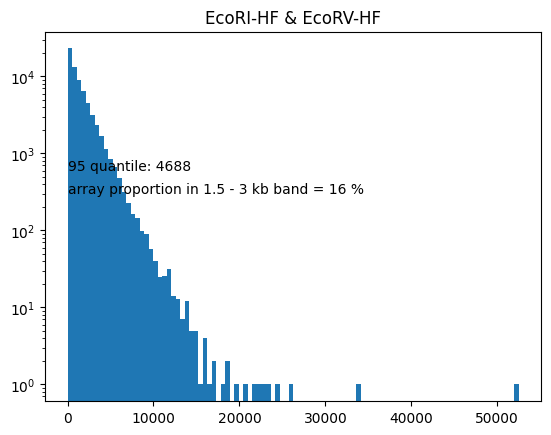

In [35]:
digest("EcoRI-HF", "EcoRV-HF")

In [38]:
print(enzymes)
def select_digest(zyme1, zyme2, cutsize):
    all_chr_fragment_lengths = []
    for chr in chromosomes:
        enzyme_1_df = enzyme_list.query('Chr == @chr & name == @zyme1')
        enzyme_2_df = enzyme_list.query('Chr == @chr & name == @zyme2')
        # Querying the chromosomes and enzymes provided and return a new dataframe
        list_of_enzyme_1_cutsites = enzyme_1_df['cutsite'].to_list()
        list_of_enzyme_2_cutsites = enzyme_2_df['cutsite'].to_list()
        # Making lists for the two enzyme cutting sites
        list_of_enzyme_1_cutsites.append(1)
        list_of_enzyme_1_cutsites.append(Chrom_sizes[chr])
        list_of_enzyme_2_cutsites.append(1)
        list_of_enzyme_2_cutsites.append(Chrom_sizes[chr])
        # Add "1" and "chromosome length" to the list
        set_of_cutsites_1 = set(list_of_enzyme_1_cutsites)
        list_of_enzyme_1_cutsites = list(set_of_cutsites_1)
        list_of_enzyme_1_cutsites.sort()
        set_enzyme_2 = set(list_of_enzyme_2_cutsites)
        list_of_enzyme_2_cutsites = list(set_enzyme_2)
        list_of_enzyme_2_cutsites.sort()
        # Render the cut sites unique

        selected_fragment = []
        last_position = 1
        for i in range(0, len(list_of_enzyme_1_cutsites)):
            if (list_of_enzyme_1_cutsites[i] - last_position != 0) and (list_of_enzyme_1_cutsites[i] - last_position < cutsize):
                fragment = []
                fragment.append(last_position)
                fragment.append(list_of_enzyme_1_cutsites[i])
                selected_fragment.append(fragment)
            last_position = list_of_enzyme_1_cutsites[i]
        # Size selection after having digested the genome with zyme1, discard all the fragments above the cutsize

        doubledigest_fragment = selected_fragment
        for site in list_of_enzyme_2_cutsites:
            for fragment in doubledigest_fragment:
                if (site > fragment[0]) and (site < fragment[1]):
                    new_fragment1 = [fragment[0], site]
                    new_fragment2 = [site, fragment[1]]
                    doubledigest_fragment.remove(fragment)
                    doubledigest_fragment.append(new_fragment1)
                    doubledigest_fragment.append(new_fragment2)
        # Digesting the selected fragments with zyme2

        for fragment in doubledigest_fragment:
            all_chr_fragment_lengths.append(fragment[1] - fragment[0])
    
    target_fragment_basepair = 0
    for i in all_chr_fragment_lengths:
        if (i > 1500) and (i < 3000):
            target_fragment_basepair += i
    ratio = round(500000000/target_fragment_basepair)
    
    #plt.figure(figsize=(10, 6))
    plt.hist(all_chr_fragment_lengths, bins=100,  label=str(zyme1 + ' & ' + zyme2 + " cutoff size = " + str(cutsize)))
    plt.title(str(zyme1 + ' & ' + zyme2 + " cutoff size = " + str(cutsize)))
    q95 = np.quantile(all_chr_fragment_lengths, q=0.95)
    plt.text(0, 600, "95 quantile: " + str(round(q95)))
    plt.text(0, 300, "array proportion in 1.5 - 3 kb band = " + str(ratio) + " %")
    plt.yscale("log")
    #plt.xlim(0,df['length'].max())
    plt.savefig(zyme1 + ' & ' + zyme2 + " cutoff size = " + str(cutsize))
    plt.show()

['SapI' 'ApaI' 'XhoI' 'BamHI-HF' 'NaeI' 'NcoI' 'SacI-HF' 'NdeI' 'SalI-HF'
 'PstI-HF' 'BsmAI' 'XbaI' 'BglII' 'AflII' 'ApaLI' 'EagI-HF' 'EcoRI-HF'
 'PvuII' 'EcoRV-HF' 'PmlI' 'NheI' 'SacII' 'KpnI-HF' 'HindIII-HF' 'HpaII'
 'DpnI' 'DraI' 'MboI']


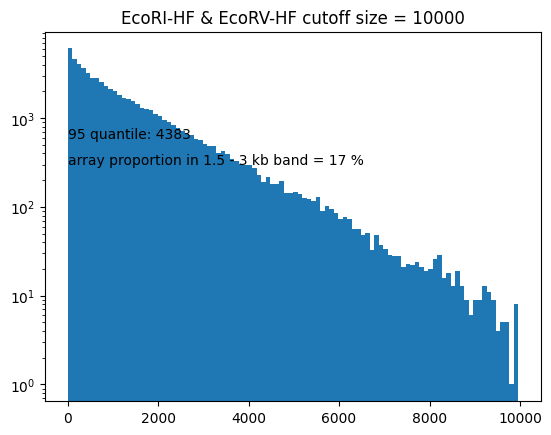

In [39]:
select_digest("EcoRI-HF", "EcoRV-HF", 10000)